In [91]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
#You can import other libraries if you want

In [92]:
###### DO NOT MODIFY THIS PART
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
######

In [93]:
artists = pd.read_csv('train/artists.csv')
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 0].reset_index()
artists_top = artists_top[['name', 'paintings']]


updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

In [94]:
# Explore images of top artists
images_dir = 'train/images' #Type Your Own Data Directory
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("find -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

find --> train/images\Vincent_van_Gogh
find --> train/images\Edgar_Degas
find --> train/images\Pablo_Picasso
find --> train/images\Pierre-Auguste_Renoir
find --> train/images\Albrecht_Dürer
find --> train/images\Paul_Gauguin
find --> train/images\Francisco_Goya
find --> train/images\Rembrandt
find --> train/images\Alfred_Sisley
find --> train/images\Titian
find --> train/images\Marc_Chagall


In [95]:
batch_size = 16 #Type your own batch size
input_shape = (224,224,3,) #Type your own input shape
n_classes = artists_top.shape[0]
flip = True,
#Image data generate with validation data fraction of 0.2 and data rescale 1/255.
# We also generate more images with vertical and horizontal flips
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255,
                                   vertical_flip=flip,
                                   horizontal_flip=flip
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3092 images belonging to 11 classes.
Found 767 images belonging to 11 classes.
Total number of batches = 193 and 47


# Summary of the model

In [96]:
# This cell is solely for getting the summary of model 
model = keras.models.Sequential([
                                 keras.layers.Conv2D(64,7,activation="relu",padding="same",
                                                     input_shape=input_shape),
                                 keras.layers.MaxPooling2D(2),
                                 keras.layers.Conv2D(128,3,activation="relu",padding="same"),
                                 keras.layers.Conv2D(128,3,activation="relu",padding="same"),
                                 keras.layers.MaxPooling2D(2),
                                 keras.layers.Conv2D(256,3,activation="relu",padding="same"),
                                 keras.layers.Conv2D(256,3,activation="relu",padding="same"),
                                 keras.layers.MaxPooling2D(2),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(128,activation="relu"),
                                 keras.layers.Dropout(0.5),
                                 keras.layers.Dense(64,activation="relu"),
                                 keras.layers.Dropout(0.5),
                                 keras.layers.Dense(n_classes,activation="softmax")
                                 
    ])
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 224, 224, 64)      9472      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 56, 56, 256)     

# Training the model

In [97]:
def get_history(optimizer=None,model_name="my_model.h5",input_shape=None):
    """
    This function trains the model and returns its accuracy, loss information for plot
    -----------
    Parameters:
    -----------
    @param optimizer: the optimizer that model will be trained with
    @param model_name: the filename of the model that will be saved on machine
    @param input_shape: the input shape that model will accept
    -----------
    Return: accuracy and loss information
    """
    model = keras.models.Sequential([
                                 keras.layers.Conv2D(64,7,activation="relu",padding="same",
                                                     input_shape=input_shape),
                                 keras.layers.MaxPooling2D(2),
                                 keras.layers.Conv2D(128,3,activation="relu",padding="same"),
                                 keras.layers.Conv2D(128,3,activation="relu",padding="same"),
                                 keras.layers.MaxPooling2D(2),
                                 keras.layers.Conv2D(256,3,activation="relu",padding="same"),
                                 keras.layers.Conv2D(256,3,activation="relu",padding="same"),
                                 keras.layers.MaxPooling2D(2),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(128,activation="relu"),
                                 keras.layers.Dropout(0.5),
                                 keras.layers.Dense(64,activation="relu"),
                                 keras.layers.Dropout(0.5),
                                 keras.layers.Dense(n_classes,activation="softmax")
                                 
    ])
    model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
    #training
    earlyVal = EarlyStopping(monitor="val_loss",patience=40,mode="auto")
    earlyTra = EarlyStopping(monitor="loss",patience=40,mode="auto")
    n_epoch = 200 #Your Own Epoch num
    history = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch, callbacks=[earlyVal,earlyTra])
    model.save(model_name)
    his = {}
    his['loss'] = history.history['loss']
    his['accuracy'] = history.history['accuracy'] 
    his['val_loss'] = history.history['val_loss']
    his['val_accuracy'] = history.history['val_accuracy']
    return his

In [98]:
# Plot the training graph
def plot_training(history,optimizer_name=None):
    """
    This function plots the training graph
    -----------
    Parameters:
    -----------
    @param history: the accuracy and loss information of the model
    @param optimizer_name: the optimizer that is used for model
    -----------
    Return: plots the graph
    """
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title(f'Training and Validation Accuracy - {optimizer_name}')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title(f'Training and Validation Loss - {optimizer_name}')
    axes[1].legend(loc='best')
    
    plt.show()

In [101]:
# Training with low learning rate to avoid fluctuations in loss
lr = 0.00005
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
his = get_history(optimizer=optimizer,model_name="adam_model.h5",input_shape=input_shape)

Epoch 1/200
193/193 [==============================] - 58s 296ms/step - loss: 2.3082 - accuracy: 0.1921 - val_loss: 2.3043 - val_accuracy: 0.2168
Epoch 2/200
193/193 [==============================] - 58s 299ms/step - loss: 2.2561 - accuracy: 0.2116 - val_loss: 2.1931 - val_accuracy: 0.3072
Epoch 3/200
193/193 [==============================] - 77s 399ms/step - loss: 2.1873 - accuracy: 0.2412 - val_loss: 2.1477 - val_accuracy: 0.3577
Epoch 4/200
193/193 [==============================] - 57s 296ms/step - loss: 2.1485 - accuracy: 0.2604 - val_loss: 2.0689 - val_accuracy: 0.3843
Epoch 5/200
193/193 [==============================] - 56s 292ms/step - loss: 2.1126 - accuracy: 0.2604 - val_loss: 2.0050 - val_accuracy: 0.3497
Epoch 6/200
193/193 [==============================] - 56s 289ms/step - loss: 2.0884 - accuracy: 0.2796 - val_loss: 1.9583 - val_accuracy: 0.3604
Epoch 7/200
193/193 [==============================] - 56s 291ms/step - loss: 2.0497 - accuracy: 0.2926 - val_loss: 1.8894 -

Epoch 57/200
193/193 [==============================] - 54s 282ms/step - loss: 1.0549 - accuracy: 0.6541 - val_loss: 1.2826 - val_accuracy: 0.6077
Epoch 58/200
193/193 [==============================] - 54s 281ms/step - loss: 1.0712 - accuracy: 0.6417 - val_loss: 1.2934 - val_accuracy: 0.6170
Epoch 59/200
193/193 [==============================] - 54s 281ms/step - loss: 1.0568 - accuracy: 0.6375 - val_loss: 1.2809 - val_accuracy: 0.6184
Epoch 60/200
193/193 [==============================] - 55s 287ms/step - loss: 1.0157 - accuracy: 0.6573 - val_loss: 1.3243 - val_accuracy: 0.6170
Epoch 61/200
193/193 [==============================] - 56s 292ms/step - loss: 1.0161 - accuracy: 0.6456 - val_loss: 1.2421 - val_accuracy: 0.6210
Epoch 62/200
193/193 [==============================] - 57s 293ms/step - loss: 1.0127 - accuracy: 0.6678 - val_loss: 1.3416 - val_accuracy: 0.5984
Epoch 63/200
193/193 [==============================] - 56s 290ms/step - loss: 0.9643 - accuracy: 0.6762 - val_loss: 1

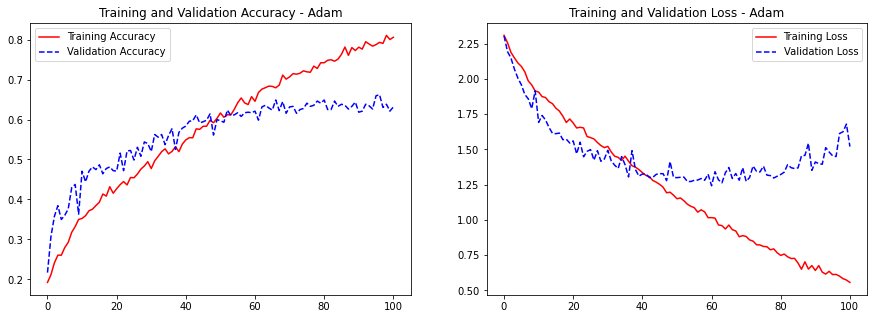

In [102]:
plot_training(his,"Adam")

# Ablation Study

Training with SGD, RMSProp, AdaGrad, AdaMax, AdaDelta optimizers

In [103]:
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
his = get_history(optimizer=optimizer,model_name="sgd_model.h5",input_shape=input_shape)

Epoch 1/200
193/193 [==============================] - 60s 309ms/step - loss: 2.3998 - accuracy: 0.0998 - val_loss: 2.3873 - val_accuracy: 0.2168
Epoch 2/200
193/193 [==============================] - 59s 308ms/step - loss: 2.3862 - accuracy: 0.1404 - val_loss: 2.3776 - val_accuracy: 0.2141
Epoch 3/200
193/193 [==============================] - 57s 294ms/step - loss: 2.3804 - accuracy: 0.1434 - val_loss: 2.3690 - val_accuracy: 0.2154
Epoch 4/200
193/193 [==============================] - 56s 288ms/step - loss: 2.3726 - accuracy: 0.1479 - val_loss: 2.3613 - val_accuracy: 0.2154
Epoch 5/200
193/193 [==============================] - 57s 296ms/step - loss: 2.3687 - accuracy: 0.1463 - val_loss: 2.3553 - val_accuracy: 0.2168
Epoch 6/200
193/193 [==============================] - 58s 302ms/step - loss: 2.3659 - accuracy: 0.1479 - val_loss: 2.3482 - val_accuracy: 0.2194
Epoch 7/200
193/193 [==============================] - 56s 290ms/step - loss: 2.3607 - accuracy: 0.1476 - val_loss: 2.3449 -

Epoch 57/200
193/193 [==============================] - 56s 289ms/step - loss: 2.3266 - accuracy: 0.1798 - val_loss: 2.2857 - val_accuracy: 0.2181
Epoch 58/200
193/193 [==============================] - 56s 289ms/step - loss: 2.3188 - accuracy: 0.1743 - val_loss: 2.2822 - val_accuracy: 0.2207
Epoch 59/200
193/193 [==============================] - 56s 289ms/step - loss: 2.3177 - accuracy: 0.1775 - val_loss: 2.2837 - val_accuracy: 0.2181
Epoch 60/200
193/193 [==============================] - 56s 288ms/step - loss: 2.3182 - accuracy: 0.1899 - val_loss: 2.2846 - val_accuracy: 0.2141
Epoch 61/200
193/193 [==============================] - 56s 291ms/step - loss: 2.3032 - accuracy: 0.1908 - val_loss: 2.2773 - val_accuracy: 0.2194
Epoch 62/200
193/193 [==============================] - 56s 290ms/step - loss: 2.3220 - accuracy: 0.1834 - val_loss: 2.2816 - val_accuracy: 0.2154
Epoch 63/200
193/193 [==============================] - 56s 289ms/step - loss: 2.3154 - accuracy: 0.1908 - val_loss: 2

193/193 [==============================] - 54s 280ms/step - loss: 2.2419 - accuracy: 0.2347 - val_loss: 2.1800 - val_accuracy: 0.2819
Epoch 168/200
193/193 [==============================] - 54s 281ms/step - loss: 2.2260 - accuracy: 0.2383 - val_loss: 2.1807 - val_accuracy: 0.2726
Epoch 169/200
193/193 [==============================] - 56s 292ms/step - loss: 2.2364 - accuracy: 0.2324 - val_loss: 2.1808 - val_accuracy: 0.2819
Epoch 170/200
193/193 [==============================] - 56s 289ms/step - loss: 2.2324 - accuracy: 0.2422 - val_loss: 2.1772 - val_accuracy: 0.2779
Epoch 171/200
193/193 [==============================] - 56s 287ms/step - loss: 2.2333 - accuracy: 0.2341 - val_loss: 2.1781 - val_accuracy: 0.2832
Epoch 172/200
193/193 [==============================] - 55s 287ms/step - loss: 2.2408 - accuracy: 0.2276 - val_loss: 2.1780 - val_accuracy: 0.2832
Epoch 173/200
193/193 [==============================] - 55s 287ms/step - loss: 2.2278 - accuracy: 0.2412 - val_loss: 2.1726 -

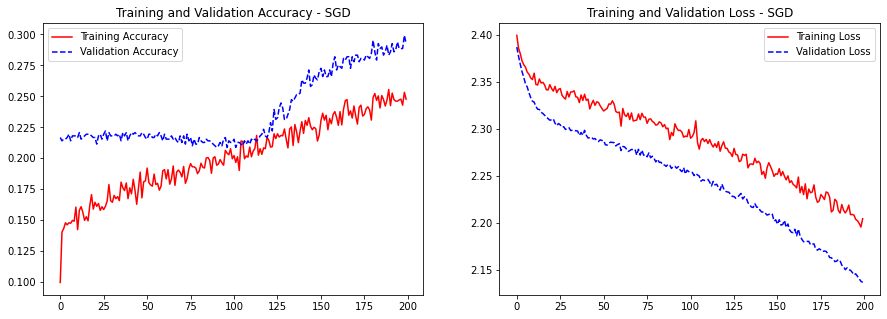

In [104]:
plot_training(his,"SGD")

In [105]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=lr)
his = get_history(optimizer=optimizer,model_name="adagrad_model.h5",input_shape=input_shape)

Epoch 1/200
193/193 [==============================] - 57s 292ms/step - loss: 2.3816 - accuracy: 0.1307 - val_loss: 2.3633 - val_accuracy: 0.1715
Epoch 2/200
193/193 [==============================] - 56s 287ms/step - loss: 2.3623 - accuracy: 0.1427 - val_loss: 2.3387 - val_accuracy: 0.1729
Epoch 3/200
193/193 [==============================] - 55s 286ms/step - loss: 2.3492 - accuracy: 0.1590 - val_loss: 2.3214 - val_accuracy: 0.2168
Epoch 4/200
193/193 [==============================] - 55s 286ms/step - loss: 2.3441 - accuracy: 0.1622 - val_loss: 2.3084 - val_accuracy: 0.2301
Epoch 5/200
193/193 [==============================] - 56s 288ms/step - loss: 2.3424 - accuracy: 0.1642 - val_loss: 2.3049 - val_accuracy: 0.2154
Epoch 6/200
193/193 [==============================] - 55s 286ms/step - loss: 2.3343 - accuracy: 0.1635 - val_loss: 2.2966 - val_accuracy: 0.2207
Epoch 7/200
193/193 [==============================] - 55s 287ms/step - loss: 2.3432 - accuracy: 0.1625 - val_loss: 2.2987 -

Epoch 57/200
193/193 [==============================] - 55s 286ms/step - loss: 2.2214 - accuracy: 0.2159 - val_loss: 2.1421 - val_accuracy: 0.2886
Epoch 58/200
193/193 [==============================] - 55s 286ms/step - loss: 2.2006 - accuracy: 0.2207 - val_loss: 2.1323 - val_accuracy: 0.2633
Epoch 59/200
193/193 [==============================] - 55s 285ms/step - loss: 2.2154 - accuracy: 0.2142 - val_loss: 2.1321 - val_accuracy: 0.3032
Epoch 60/200
193/193 [==============================] - 55s 285ms/step - loss: 2.2132 - accuracy: 0.2240 - val_loss: 2.1287 - val_accuracy: 0.2713
Epoch 61/200
193/193 [==============================] - 55s 286ms/step - loss: 2.2108 - accuracy: 0.2276 - val_loss: 2.1280 - val_accuracy: 0.2886
Epoch 62/200
193/193 [==============================] - 58s 299ms/step - loss: 2.2180 - accuracy: 0.2302 - val_loss: 2.1329 - val_accuracy: 0.2992
Epoch 63/200
193/193 [==============================] - 56s 288ms/step - loss: 2.2138 - accuracy: 0.2201 - val_loss: 2

193/193 [==============================] - 55s 283ms/step - loss: 2.0932 - accuracy: 0.2955 - val_loss: 1.9741 - val_accuracy: 0.3670
Epoch 168/200
193/193 [==============================] - 54s 281ms/step - loss: 2.0798 - accuracy: 0.3066 - val_loss: 1.9711 - val_accuracy: 0.3737
Epoch 169/200
193/193 [==============================] - 54s 281ms/step - loss: 2.0805 - accuracy: 0.2984 - val_loss: 1.9609 - val_accuracy: 0.3790
Epoch 170/200
193/193 [==============================] - 54s 281ms/step - loss: 2.0620 - accuracy: 0.3114 - val_loss: 1.9532 - val_accuracy: 0.3777
Epoch 171/200
193/193 [==============================] - 54s 281ms/step - loss: 2.0844 - accuracy: 0.2978 - val_loss: 1.9599 - val_accuracy: 0.3710
Epoch 172/200
193/193 [==============================] - 54s 282ms/step - loss: 2.0613 - accuracy: 0.3023 - val_loss: 1.9621 - val_accuracy: 0.3777
Epoch 173/200
193/193 [==============================] - 54s 282ms/step - loss: 2.0685 - accuracy: 0.2952 - val_loss: 1.9631 -

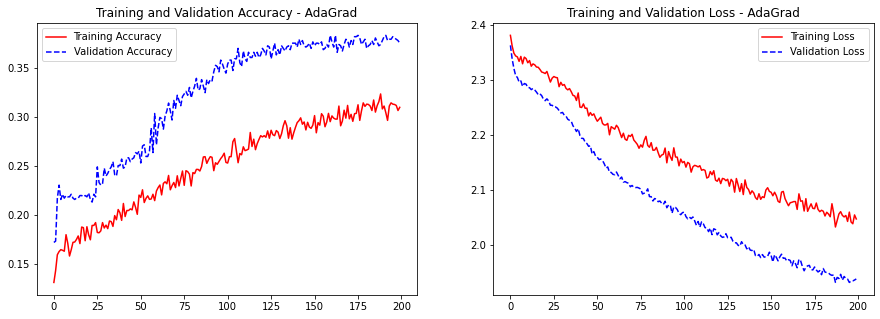

In [106]:
plot_training(his,"AdaGrad")

In [107]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
his = get_history(optimizer=optimizer,model_name="rmsprop_model.h5",input_shape=input_shape)

Epoch 1/200
193/193 [==============================] - 57s 287ms/step - loss: 2.3252 - accuracy: 0.1824 - val_loss: 2.2198 - val_accuracy: 0.2660
Epoch 2/200
193/193 [==============================] - 55s 286ms/step - loss: 2.2493 - accuracy: 0.2129 - val_loss: 2.1952 - val_accuracy: 0.2287
Epoch 3/200
193/193 [==============================] - 55s 285ms/step - loss: 2.1872 - accuracy: 0.2454 - val_loss: 2.0666 - val_accuracy: 0.3524
Epoch 4/200
193/193 [==============================] - 55s 284ms/step - loss: 2.1641 - accuracy: 0.2493 - val_loss: 2.0655 - val_accuracy: 0.3577
Epoch 5/200
193/193 [==============================] - 55s 284ms/step - loss: 2.1244 - accuracy: 0.2731 - val_loss: 2.0134 - val_accuracy: 0.3777
Epoch 6/200
193/193 [==============================] - 55s 284ms/step - loss: 2.0684 - accuracy: 0.2952 - val_loss: 1.9036 - val_accuracy: 0.4255
Epoch 7/200
193/193 [==============================] - 55s 284ms/step - loss: 2.0345 - accuracy: 0.3108 - val_loss: 1.8769 -

Epoch 112/200
193/193 [==============================] - 54s 279ms/step - loss: 1.1122 - accuracy: 0.6495 - val_loss: 1.3881 - val_accuracy: 0.6037
Epoch 113/200
193/193 [==============================] - 54s 279ms/step - loss: 1.1656 - accuracy: 0.6499 - val_loss: 1.2967 - val_accuracy: 0.6503
Epoch 114/200
193/193 [==============================] - 54s 280ms/step - loss: 1.1323 - accuracy: 0.6599 - val_loss: 1.1961 - val_accuracy: 0.6516
Epoch 115/200
193/193 [==============================] - 54s 280ms/step - loss: 1.1282 - accuracy: 0.6521 - val_loss: 1.1764 - val_accuracy: 0.6463
Epoch 116/200
193/193 [==============================] - 54s 279ms/step - loss: 1.1316 - accuracy: 0.6531 - val_loss: 1.2483 - val_accuracy: 0.6263
Epoch 117/200
193/193 [==============================] - 54s 279ms/step - loss: 1.0961 - accuracy: 0.6590 - val_loss: 1.2564 - val_accuracy: 0.6210


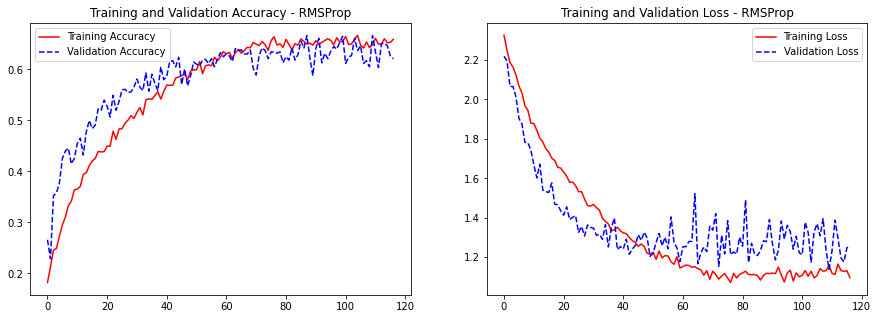

In [108]:
plot_training(his,"RMSProp")

In [109]:
optimizer = tf.keras.optimizers.Adadelta(learning_rate=lr)
his = get_history(optimizer=optimizer,model_name="adadelta_model.h5",input_shape=input_shape)

Epoch 1/200
193/193 [==============================] - 55s 280ms/step - loss: 2.3920 - accuracy: 0.1209 - val_loss: 2.3861 - val_accuracy: 0.2194
Epoch 2/200
193/193 [==============================] - 54s 280ms/step - loss: 2.3820 - accuracy: 0.1596 - val_loss: 2.3764 - val_accuracy: 0.2114
Epoch 3/200
193/193 [==============================] - 54s 279ms/step - loss: 2.3775 - accuracy: 0.1642 - val_loss: 2.3685 - val_accuracy: 0.2181
Epoch 4/200
193/193 [==============================] - 54s 280ms/step - loss: 2.3720 - accuracy: 0.1821 - val_loss: 2.3599 - val_accuracy: 0.2207
Epoch 5/200
193/193 [==============================] - 54s 280ms/step - loss: 2.3635 - accuracy: 0.1876 - val_loss: 2.3546 - val_accuracy: 0.2181
Epoch 6/200
193/193 [==============================] - 54s 280ms/step - loss: 2.3610 - accuracy: 0.1821 - val_loss: 2.3484 - val_accuracy: 0.2181
Epoch 7/200
193/193 [==============================] - 54s 280ms/step - loss: 2.3560 - accuracy: 0.1834 - val_loss: 2.3416 -

Epoch 57/200
193/193 [==============================] - 54s 282ms/step - loss: 2.3039 - accuracy: 0.1951 - val_loss: 2.2688 - val_accuracy: 0.2141
Epoch 58/200
193/193 [==============================] - 54s 280ms/step - loss: 2.3029 - accuracy: 0.1983 - val_loss: 2.2647 - val_accuracy: 0.2207
Epoch 59/200
193/193 [==============================] - 55s 285ms/step - loss: 2.3142 - accuracy: 0.1970 - val_loss: 2.2659 - val_accuracy: 0.2207
Epoch 60/200
193/193 [==============================] - 55s 284ms/step - loss: 2.3059 - accuracy: 0.1921 - val_loss: 2.2677 - val_accuracy: 0.2168
Epoch 61/200
193/193 [==============================] - 54s 281ms/step - loss: 2.3061 - accuracy: 0.1908 - val_loss: 2.2634 - val_accuracy: 0.2181
Epoch 62/200
193/193 [==============================] - 54s 282ms/step - loss: 2.3064 - accuracy: 0.1990 - val_loss: 2.2654 - val_accuracy: 0.2194
Epoch 63/200
193/193 [==============================] - 54s 281ms/step - loss: 2.2988 - accuracy: 0.2116 - val_loss: 2

193/193 [==============================] - 54s 279ms/step - loss: 2.2798 - accuracy: 0.1915 - val_loss: 2.2445 - val_accuracy: 0.2154
Epoch 168/200
193/193 [==============================] - 55s 283ms/step - loss: 2.2751 - accuracy: 0.2051 - val_loss: 2.2417 - val_accuracy: 0.2181
Epoch 169/200
193/193 [==============================] - 55s 285ms/step - loss: 2.2884 - accuracy: 0.1986 - val_loss: 2.2453 - val_accuracy: 0.2154
Epoch 170/200
193/193 [==============================] - 56s 289ms/step - loss: 2.2842 - accuracy: 0.1990 - val_loss: 2.2424 - val_accuracy: 0.2168
Epoch 171/200
193/193 [==============================] - 55s 283ms/step - loss: 2.2770 - accuracy: 0.2058 - val_loss: 2.2384 - val_accuracy: 0.2194
Epoch 172/200
193/193 [==============================] - 54s 282ms/step - loss: 2.2864 - accuracy: 0.1928 - val_loss: 2.2446 - val_accuracy: 0.2181
Epoch 173/200
193/193 [==============================] - 54s 279ms/step - loss: 2.2784 - accuracy: 0.2029 - val_loss: 2.2424 -

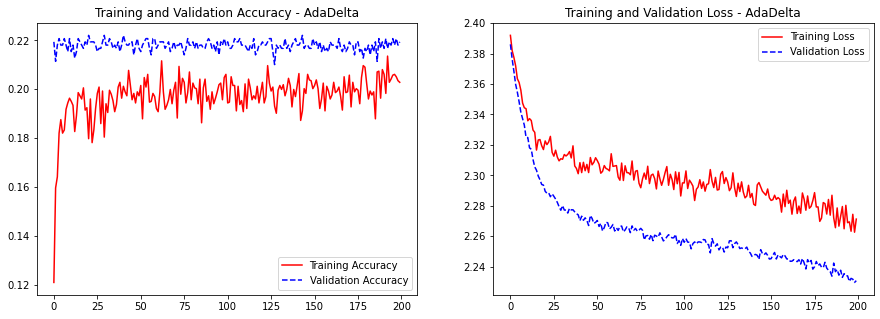

In [110]:
plot_training(his,"AdaDelta")

In [111]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=lr)
his = get_history(optimizer=optimizer,model_name="adamax_model.h5",input_shape=input_shape)

Epoch 1/200
193/193 [==============================] - 55s 283ms/step - loss: 2.3365 - accuracy: 0.1557 - val_loss: 2.2358 - val_accuracy: 0.2207
Epoch 2/200
193/193 [==============================] - 54s 282ms/step - loss: 2.2887 - accuracy: 0.1739 - val_loss: 2.1893 - val_accuracy: 0.2806
Epoch 3/200
193/193 [==============================] - 54s 281ms/step - loss: 2.2455 - accuracy: 0.2019 - val_loss: 2.1443 - val_accuracy: 0.2952
Epoch 4/200
193/193 [==============================] - 54s 281ms/step - loss: 2.2264 - accuracy: 0.2133 - val_loss: 2.1102 - val_accuracy: 0.3285
Epoch 5/200
193/193 [==============================] - 54s 280ms/step - loss: 2.1692 - accuracy: 0.2507 - val_loss: 2.0610 - val_accuracy: 0.3404
Epoch 6/200
193/193 [==============================] - 54s 280ms/step - loss: 2.1512 - accuracy: 0.2588 - val_loss: 2.0127 - val_accuracy: 0.3484
Epoch 7/200
193/193 [==============================] - 54s 280ms/step - loss: 2.1274 - accuracy: 0.2695 - val_loss: 1.9769 -

Epoch 57/200
193/193 [==============================] - 54s 279ms/step - loss: 1.6093 - accuracy: 0.4506 - val_loss: 1.4782 - val_accuracy: 0.5439
Epoch 58/200
193/193 [==============================] - 54s 278ms/step - loss: 1.6064 - accuracy: 0.4516 - val_loss: 1.4424 - val_accuracy: 0.5439
Epoch 59/200
193/193 [==============================] - 54s 280ms/step - loss: 1.5984 - accuracy: 0.4597 - val_loss: 1.4558 - val_accuracy: 0.5293
Epoch 60/200
193/193 [==============================] - 54s 279ms/step - loss: 1.6046 - accuracy: 0.4587 - val_loss: 1.4349 - val_accuracy: 0.5412
Epoch 61/200
193/193 [==============================] - 54s 279ms/step - loss: 1.5695 - accuracy: 0.4639 - val_loss: 1.4623 - val_accuracy: 0.5253
Epoch 62/200
193/193 [==============================] - 54s 279ms/step - loss: 1.6008 - accuracy: 0.4652 - val_loss: 1.4245 - val_accuracy: 0.5266
Epoch 63/200
193/193 [==============================] - 54s 278ms/step - loss: 1.5842 - accuracy: 0.4681 - val_loss: 1

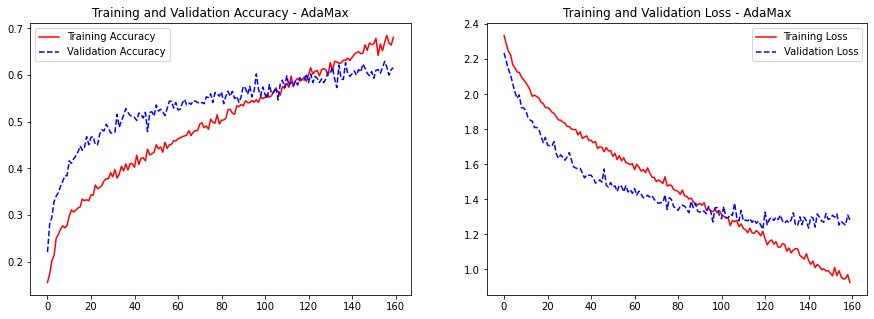

In [112]:
plot_training(his,"AdaMax")